In [45]:
from pathlib import Path

import numpy as np
import pypulseq as pp
from bmc.utils.seq.write import write_seq

import matplotlib.pyplot as plt

In [46]:
try:
    seqid = Path(__file__).stem + "_python"
    folder = Path(__file__).parent
except NameError:
    seqid = "simple_gauss"
    folder = Path(".")

In [47]:
# general settings
AUTHOR = "DANIEL MIKSCH"
FLAG_PLOT_SEQUENCE = True  # plot preparation block?
FLAG_CHECK_TIMING = True  # perform a timing check at the end of the sequence?
FLAG_POST_PREP_SPOIL = True  # add spoiler after preparation block?

# sequence definitions
defs: dict = {}
defs["a"] = 90 # a in degrees
defs["b0"] = 17  # B0 [T]

# defs["trec_m0"] = 12  # recovery time before M0 [s]
defs["m0_offset"] = 0  # m0 offset [ppm]
defs["offsets_ppm"] = np.array([defs["m0_offset"]])

defs["num_meas"] = defs["offsets_ppm"].size  # number of repetition

defs["seq_id_string"] = seqid  # unique seq id


seq_filename = defs["seq_id_string"] + ".seq"

In [48]:
sys = pp.Opts(
    max_grad=1250,
    grad_unit="mT/m",
    max_slew=1000,
    slew_unit="T/m/s",
    rf_ringdown_time=0,
    rf_dead_time=0,
    rf_raster_time=1e-6,
    gamma=42576400,
)

GAMMA_HZ = sys.gamma * 1e-6
defs["freq"] = defs["b0"] * GAMMA_HZ  # Larmor frequency [Hz]

In [49]:
# ===========
# PREPARATION
# ===========


# rf pulse
flip_angle = np.radians(defs['a'])
t_pulse = 10e-3
# bandwidth_read = 

rf_90 = pp.make_gauss_pulse(
    flip_angle=flip_angle,
    system=sys,
    duration=t_pulse,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)


#pseudo adc
pseudo_adc = pp.make_adc(num_samples=1, duration=1e-3)


In [50]:
seq = pp.Sequence()

offsets_hz = defs["offsets_ppm"] * defs["freq"]  # convert from ppm to Hz

In [51]:

rf_90.freq_offset = 0

seq.add_block(rf_90)
seq.add_block(pseudo_adc)

if FLAG_CHECK_TIMING:
    ok, error_report = seq.check_timing()
if ok:
    print("\nTiming check passed successfully")
else:
    print("\nTiming check failed! Error listing follows\n")
    print(error_report)


Timing check passed successfully


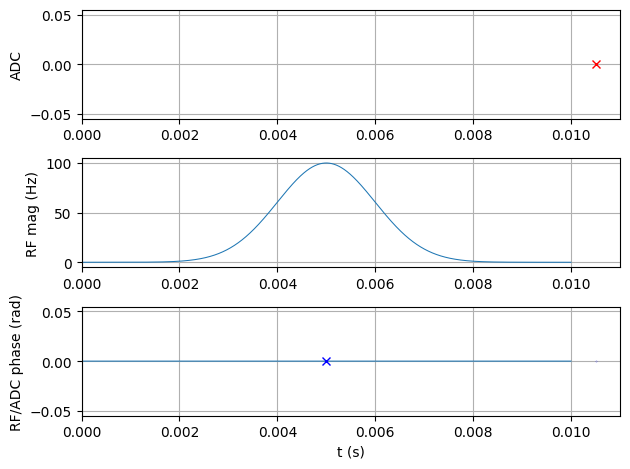

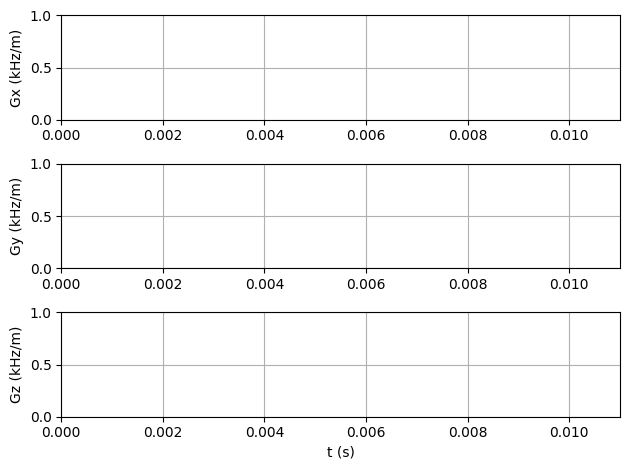

In [52]:
if FLAG_PLOT_SEQUENCE:
    seq.plot() #time_range=[0.00, .03]

In [53]:
write_seq(seq=seq, seq_defs=defs, filename=folder / seq_filename, author=AUTHOR, use_matlab_names=True)

In [54]:
pp.calc_rf_bandwidth(rf_90)

array([360])

In [55]:
np.radians(360)

np.float64(6.283185307179586)